## Install Libraries & Prepare the Working Directory

In [1]:
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu121.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu121.html
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.11.0+cu121.html
!pip install torch torchvision torchaudio
!pip install torch-geometric

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, HeteroConv, Linear
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [34]:
user_feat_df = pd.read_csv('user_feat.csv')
movie_feat_df = pd.read_csv('item_feat.csv')
interact_df = pd.read_csv('interact.csv')

# Create 'Liked' column based on 'Rating'
interact_df['Liked'] = (interact_df['Rating'] >= 4).astype(int)

# Prepare user and movie IDs
user_ids = user_feat_df['UserID'].unique()
movie_ids = movie_feat_df['MovieID'].unique()

# Map IDs to indices
user_id_map = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Prepare edges and features
edge_index = torch.tensor([interact_df['UserID'].map(user_id_map).tolist(),
                           interact_df['MovieID'].map(movie_id_map).tolist()], dtype=torch.long)

# Node features
user_features = torch.tensor(user_feat_df[['F', 'M']].values, dtype=torch.float)
movie_features = torch.tensor(movie_feat_df.iloc[:, 1:].values, dtype=torch.float)  # Assuming features start from column 1

# Create a HeteroData object
data = HeteroData()

# Add node features
data['user'].x = user_features
data['movie'].x = movie_features

# Add edge indices
data['user', 'rates', 'movie'].edge_index = edge_index
data['movie', 'rev_rates', 'user'].edge_index = edge_index.flip(0)

# Add labels
data['user', 'rates', 'movie'].y = torch.tensor(interact_df['Liked'].values, dtype=torch.float)

# Create masks for edges
train_indices, test_indices = train_test_split(np.arange(edge_index.size(1)), test_size=0.2, random_state=42)

edge_train_mask = torch.zeros(edge_index.size(1), dtype=torch.bool)
edge_test_mask = torch.zeros(edge_index.size(1), dtype=torch.bool)

edge_train_mask[train_indices] = True
edge_test_mask[test_indices] = True

# Assign masks to data object
data['user', 'rates', 'movie'].train_mask = edge_train_mask
data['user', 'rates', 'movie'].test_mask = edge_test_mask

In [49]:
class HeteroGraphModel(nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super(HeteroGraphModel, self).__init__()
        self.conv1 = HeteroConv({
            ('user', 'rates', 'movie'): SAGEConv((-1, -1), hidden_channels),
            ('movie', 'rev_rates', 'user'): SAGEConv((-1, -1), hidden_channels)
        }, aggr='mean')
        self.conv2 = HeteroConv({
            ('user', 'rates', 'movie'): SAGEConv((-1, -1), out_channels),
            ('movie', 'rev_rates', 'user'): SAGEConv((-1, -1), out_channels)
        }, aggr='mean')
        self.lin = nn.Linear(2 * out_channels, 1)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)

        # Aggregate user and movie embeddings for edge prediction
        user_movie_edge_index = edge_index_dict[('user', 'rates', 'movie')]
        movie_user_edge_index = edge_index_dict[('movie', 'rev_rates', 'user')]

        user_movie_embeddings = torch.cat([x_dict['user'][user_movie_edge_index[0]],
                                           x_dict['movie'][user_movie_edge_index[1]]], dim=1)
        movie_user_embeddings = torch.cat([x_dict['movie'][movie_user_edge_index[0]],
                                           x_dict['user'][movie_user_edge_index[1]]], dim=1)

        user_movie_pred = torch.sigmoid(self.lin(user_movie_embeddings)).squeeze()
        movie_user_pred = torch.sigmoid(self.lin(movie_user_embeddings)).squeeze()

        return user_movie_pred, movie_user_pred

# Training and evaluation functions
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    user_movie_pred, _ = model(data.x_dict, data.edge_index_dict)
    loss = criterion(user_movie_pred[data['user', 'rates', 'movie'].train_mask],
                     data['user', 'rates', 'movie'].y[data['user', 'rates', 'movie'].train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        user_movie_pred, _ = model(data.x_dict, data.edge_index_dict)
        pred = (user_movie_pred > 0.5).float()
        test_acc = (pred[data['user', 'rates', 'movie'].test_mask] ==
                    data['user', 'rates', 'movie'].y[data['user', 'rates', 'movie'].test_mask]).sum().item() / \
                    data['user', 'rates', 'movie'].test_mask.sum().item()
    return test_acc

Epoch: 0, Loss: 0.7013, Test Acc: 0.5760
Epoch: 10, Loss: 0.6839, Test Acc: 0.5760
Epoch: 20, Loss: 0.6807, Test Acc: 0.5758
Epoch: 30, Loss: 0.6729, Test Acc: 0.5787
Epoch: 40, Loss: 0.6689, Test Acc: 0.5917
Epoch: 50, Loss: 0.6673, Test Acc: 0.5923
Epoch: 60, Loss: 0.6660, Test Acc: 0.5961
Epoch: 70, Loss: 0.6640, Test Acc: 0.5985
Epoch: 80, Loss: 0.6578, Test Acc: 0.6114
Epoch: 90, Loss: 0.6514, Test Acc: 0.6310
Epoch: 100, Loss: 0.6412, Test Acc: 0.6313
Epoch: 110, Loss: 0.6356, Test Acc: 0.6547
Epoch: 120, Loss: 0.6332, Test Acc: 0.6598
Epoch: 130, Loss: 0.6294, Test Acc: 0.6589
Epoch: 140, Loss: 0.6281, Test Acc: 0.6619
Epoch: 150, Loss: 0.6254, Test Acc: 0.6642
Epoch: 160, Loss: 0.6246, Test Acc: 0.6614
Epoch: 170, Loss: 0.6237, Test Acc: 0.6637
Epoch: 180, Loss: 0.6240, Test Acc: 0.6642
Epoch: 190, Loss: 0.6221, Test Acc: 0.6646


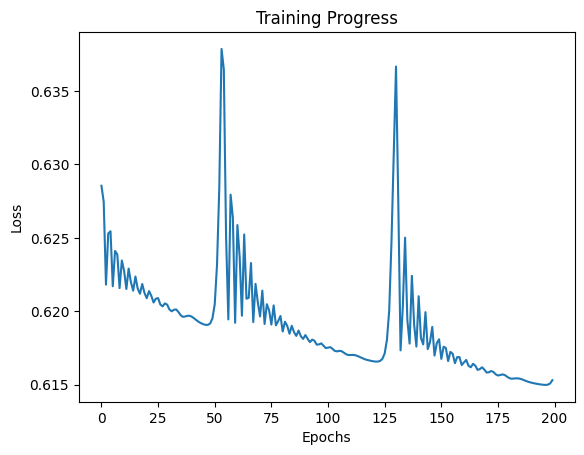

In [50]:
# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HeteroGraphModel(hidden_channels=64, out_channels=32).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.BCELoss()

# Training loop
for epoch in range(200):
    loss = train(model, data, optimizer, criterion)
    if epoch % 10 == 0:
        test_acc = test(model, data)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

# Plotting the training loss or accuracy over epochs if collected
losses = [train(model, data, optimizer, criterion) for _ in range(200)]
plt.plot(range(200), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.savefig('training_progress.png')
plt.show()